In [36]:
#If on VS code, please download Markdown as the extension to view the math in this file properly

#scipy is a library that uses numpy for more mathematical functions and is used for scientific computing like linear algebra, integration, optimization, etc.
import scipy as sc
# These are going to be your necessary imports for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# This is the library we are going to use to get the stock data, if you don't have it installed, you can install it by running 'pip install yfinance'
import yfinance as yf


In [115]:
ticker = "NVDA"  # Change to any ticker
data = yf.download(ticker, start="2021-01-01", end="2022-01-01")

#Compute log returns & volatility using "Close" prices
data["Returns"] = np.log(data["Close"] / data["Close"].shift(1))
sigma = np.std(data["Returns"].dropna()) * np.sqrt(252)  # Annualized volatility
initial = data["Close"].iloc[-1]  # Latest stock price
rate = 0.05  # Assume a 5% risk-free rate 


[*********************100%***********************]  1 of 1 completed


In [116]:

def simulation(initial, rate, sigma, Maturity, Steps, SimNum, depth=0, maxDepth=10000):
    '''
    Step Definition: A period in time which the stock price will be recalculated, the more steps, the more accurate the simulation will be. In an ideal world we would have infinite steps, but that is not possible, so we will have to settle for a large number of steps because of computing limitations.
    
    At each step our algorithm will do the following:
    1. Decide if we should exercise the option
    2. Decide if we should wait to exercise the option
    
    This following line of code will calculate the time between each step, it is calculated by the function dT (maturity) = Total Time Period/Steps, an example would be if we had a time period of 1 year, and 50 steps, the time between each step would be 1/50 or 0.2 years per step.
    
    The function will then calculate the stock price at each step, the stock price is calculated by the formula: Figure 1.1
    - The function utilizes Geometric Brownian Motion to recalculate the stock price for a random movement Z, which is from a standard distribution of 
    
    Z ~ N(0,1)
    where N is the normal distribution, and 0,1 are the mean and standard deviation respectively.
    
    '''
    if depth > maxDepth:
        print("Maximum recursion depth reached. Returning default stock paths.")
        return np.full((Steps+1, SimNum), initial)  
    # Return a constant stock price array as a fallback

    timeSteps = Maturity / Steps  
    
    ''' 
    Discount factor is used to calculate the present value of the option, it is calculated by the formula: Figure 1.2
    - The discount factor is always going to be between 0 and 1, where 0 means the option is completely worthless, and 1 means the option has no discounting where it will have the same value today as in the future
    
    '''

    # np.exp is the numpy call for the exponential function, it is used to calculate the discount factor
    discount = np.exp(-rate * timeSteps) 

    # np.zeros is a numpy function that will return an array of zeros with the specified shape
    stockPaths = np.zeros((Steps+1, SimNum))
    stockPaths[0, :] = initial

    for t in range(1, Steps+1):
        # np.random.standard_normal is a numpy function that will return an array of random numbers from a standard normal distribution N ~ (0,1)
        Z = np.random.standard_normal(SimNum)  
        stockPaths[t, :] = stockPaths[t-1, :] * np.exp((rate - 0.5 * sigma**2) * timeSteps + sigma * np.sqrt(timeSteps) * Z)

    # np.maximum is a numpy function that will return the maximum value of two arrays, in this case it will return the maximum value of the rate and stockPaths
    payMatrix = np.maximum(np.array(initial) - stockPaths, 0).astype(np.float64)

    # np.zeros_like is a numpy function that will return an array of zeros with the same shape and type as the input array
    optionValue = np.zeros_like(payMatrix)

    # The value of the option at expiration will be the same as 
    optionValue[-1, :] = payMatrix[-1, :]

    
    for t in range(Steps-1, 0, -1):  
        inTheMoney = payMatrix[t, :] > 0  

        if np.any(inTheMoney): 
            X = stockPaths[t, inTheMoney]  # Stock prices at time t
            Y = optionValue[t+1, inTheMoney] * discount  # Discounted future option values
            #polynomial regression
            regression_coeffs = np.polyfit(X, Y, deg=2) 
            continuation_value = np.polyval(regression_coeffs, X)

            # Exercise if intrinsic value > continuation value
            exercise = payMatrix[t, inTheMoney] > continuation_value

            optionValue[t, inTheMoney] = np.where(
                exercise, payMatrix[t, inTheMoney], optionValue[t+1, inTheMoney] * discount
            )
            

   
    # Find the most optimal ITM value and first step where it occurs
    # Find the step where early exercise provides the highest value
    optimal_values = np.max(optionValue, axis=1)  # Max value per step
    valid_steps = np.where(optimal_values > 0)[0]  # Ignore worthless expiration cases

    if len(valid_steps) > 0:
        optimal_step = valid_steps[np.argmax(optimal_values[valid_steps])]  # First occurrence of max value
        optimal_value = optimal_values[optimal_step]
        print(f"Most optimal in-the-money option value: {optimal_value} at step {optimal_step}")
    else:
        print("No in-the-money option value found before expiration.")

    return np.mean(optionValue[1, :]) * discount, stockPaths
    



Maturity = 1.0   # 1 year
Steps = 252      # 252 trading days
SimNum = 10000   # 10,000 Monte Carlo simulations

option_price, stock_paths = simulation(initial, rate, sigma, Maturity, Steps, SimNum, depth=0, maxDepth=10000)



Most optimal in-the-money option value: 24.26961872644587 at step 247


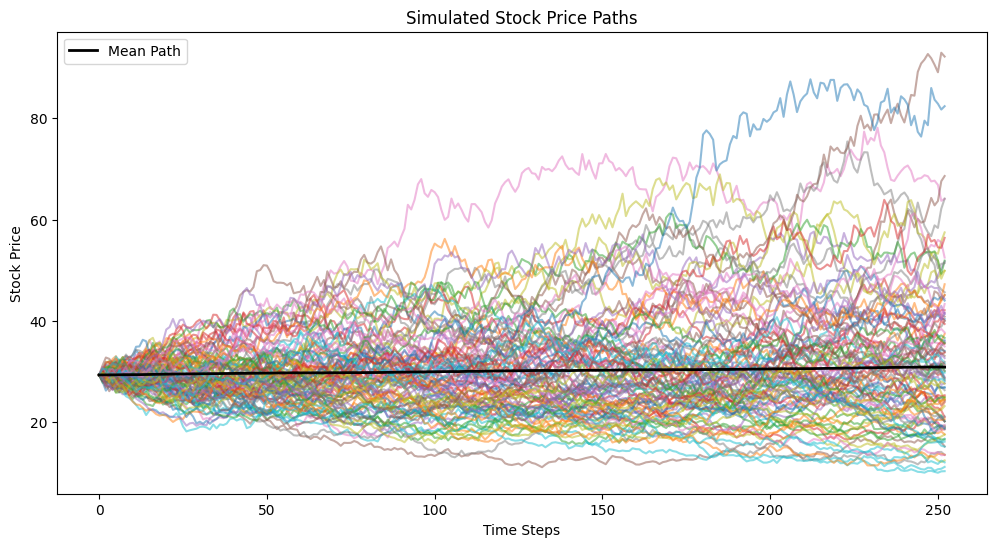

In [117]:

def plot_stock_paths(stockPaths, num_paths=100):
    plt.figure(figsize=(12, 6))

    # Plot a subset of stock paths (num_paths)
    plt.plot(stockPaths[:, :num_paths], alpha=0.5)

    # Plot mean path for reference
    plt.plot(stockPaths.mean(axis=1), color='black', linewidth=2, label="Mean Path")

    # Labels and title
    plt.xlabel("Time Steps")
    plt.ylabel("Stock Price")
    plt.title("Simulated Stock Price Paths")
    plt.legend()
    plt.show()

# Call the function with the generated stock paths
plot_stock_paths(stock_paths)


In [118]:
from IPython.display import display, Math

print("Figure 1.1 - Stock Price Simulation Formula utilizing GBM")

display(Math(r"S_{t+1} = S_t \times e^{(r - 0.5\sigma^2) dt + \sigma \sqrt{dt} Z}"))

Figure 1.1 - Stock Price Simulation Formula utilizing GBM


<IPython.core.display.Math object>

In [50]:
print("Figure 1.2 - Discount Factor Formula")
display(Math(r"D = e^{-r \cdot T}"))
print(" D = discount factor \n e = eulers number (2.71828) which is for continuous compounding \n r = risk free rate \n T = time to maturity in years")

Figure 1.2 - Discount Factor Formula


<IPython.core.display.Math object>

 D = discount factor 
 e = eulers number (2.71828) which is for continuous compounding 
 r = risk free rate 
 T = time to maturity in years
